In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent
import networks

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import data
import numpy as np
import matplotlib.pyplot as plt

mermaid unavailable, no LNCC


In [3]:
r_ds = torch.load("/playpen/tgreer/knees_real_train_set")
batched_ds = list(zip(r_ds[::3], r_ds[1::3], r_ds[2::3]))

In [4]:
BATCH_SIZE = 24
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
working_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4

tmp_affine_net = inverseConsistentNet.InverseConsistentAffineNet(
    networks.ConvolutionalMatrixNet(dimension=3),
    lmbda=100,
    input_shape=working_shape,
)

phi = networks.StumpyConvolutionalMatrixNet(dimension=3)
psi = networks.StumpyConvolutionalMatrixNet(dimension=3)
affine_net = networks.DoubleAffineNet(
    phi, psi, tmp_affine_net.identityMap, tmp_affine_net.spacing
)

net = inverseConsistentNet.InverseConsistentAffineDeformableNet(
    affine_net,
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3),
    lmbda=100,
    input_shape=working_shape,
)


In [5]:
net.adjust_batch_size(24)

trained_weights = torch.load("../results/knee_chunky_middle_7/knee_aligner_resi_net81900")
#del trained_weights["affine_regis_net.identityMap"]

In [6]:
net.load_state_dict(trained_weights)

<All keys matched successfully>

In [7]:
net.adjust_batch_size(3)
net.cuda()

InverseConsistentAffineDeformableNet(
  (affine_regis_net): DoubleAffineNet(
    (netPsi): StumpyConvolutionalMatrixNet(
      (convs): ModuleList(
        (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      )
      (dense2): Linear(in_features=4608, out_features=3000, bias=True)
      (dense3): Linear(in_features=3000, out_features=12, bias=True)
    )
    (netPhi): StumpyConvolutionalMatrixNet(
      (convs): ModuleList(
        (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (2

In [8]:
dices = []
for x in batched_ds:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)
dd = np.mean([d.item() for d in dices])
print(dd)

/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.6106, device='cuda:0')
tensor(0.4662, device='cuda:0')
tensor(0.5854, device='cuda:0')
tensor(0.6277, device='cuda:0')
tensor(0.5331, device='cuda:0')
tensor(0.5278, device='cuda:0')
tensor(0.5241, device='cuda:0')
tensor(0.4761, device='cuda:0')
tensor(0.5731, device='cuda:0')
tensor(0.5585, device='cuda:0')
tensor(0.5502, device='cuda:0')
tensor(0.5225, device='cuda:0')
tensor(0.5381, device='cuda:0')
tensor(0.5700, device='cuda:0')
tensor(0.4850, device='cuda:0')
tensor(0.5551, device='cuda:0')
tensor(0.4790, device='cuda:0')
tensor(0.4831, device='cuda:0')
tensor(0.5254, device='cuda:0')
tensor(0.5715, device='cuda:0')
tensor(0.6265, device='cuda:0')
tensor(0.5357, device='cuda:0')
tensor(0.5139, device='cuda:0')
tensor(0.5871, device='cuda:0')
tensor(0.5177, device='cuda:0')
tensor(0.5158, device='cuda:0')
tensor(0.5949, device='cuda:0')
tensor(0.4343, device='cuda:0')
tensor(0.4950, device='cuda:0')
tensor(0.5202, device='cuda:0')
tensor(0.5530, device='cuda:0')
tensor(0

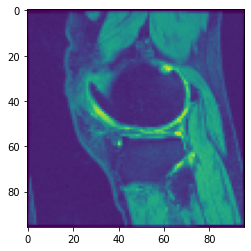

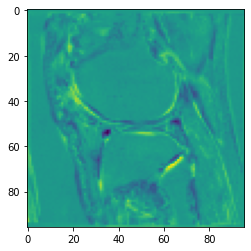

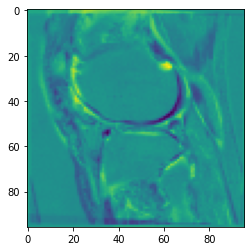

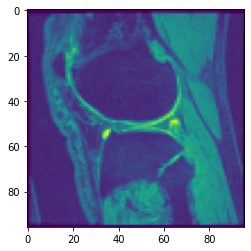

In [9]:
if not("N" in locals()):
    N = 0
N += 1
N %= 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()

plt.imshow(moving_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_A[N, 0, 10].cpu().detach() - fixed_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.affine_warped_image_A[N, 0, 10].cpu().detach() - fixed_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(fixed_image[N, 0, 10].cpu().detach())
plt.show()

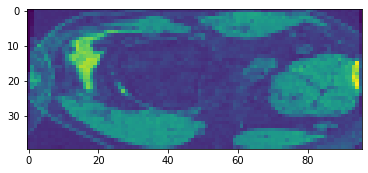

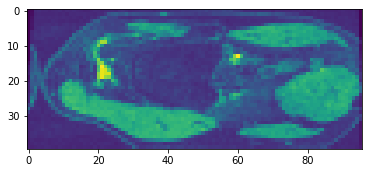

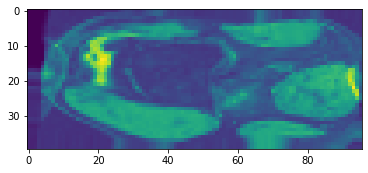

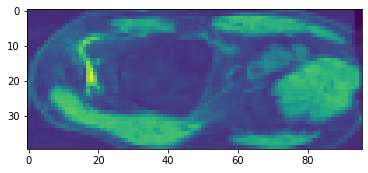

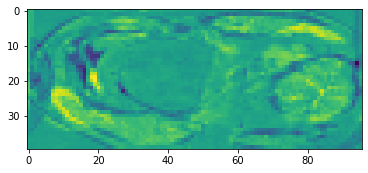

In [175]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

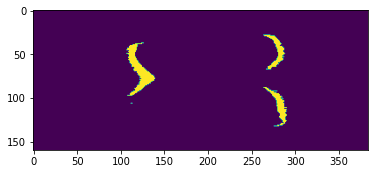

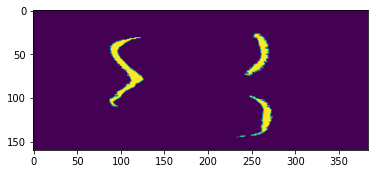

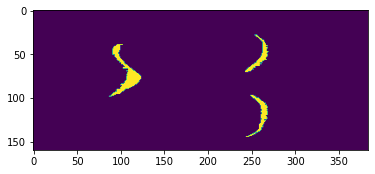

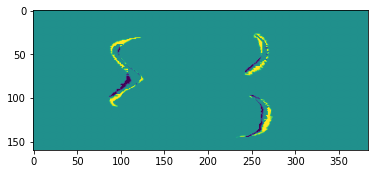

In [176]:
#N +=1
N %= 3
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

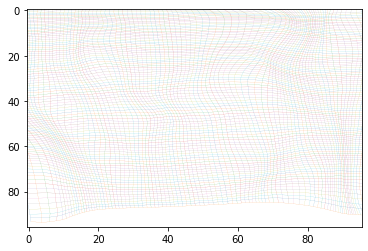

In [181]:
import visualize
visualize.show_as_grid(net.phi_AB[2, [1, 2], 20])